## Description
This introductory notebook demonstrates how to visualise datacube indexed satellite data returned from running a datacube query. Demonstrating  commonly used `xarray` plotting methods.

Topics covered in this notebook include:

1. View an area of interest prior to querying the datacube
2. Querying the datacube and loading data
3. Plotting single band data (e.g. a single satellite band)
    * Selecting and plotting individual timesteps
    * Plotting multiple timesteps
    * Customising plot appearance
4. Plotting three-band true or false colour imagery
    * Plotting single timesteps
    * Plotting multiple timesteps
    * Customising plot appearance

***

In [30]:
import sys
sys.path.append("./utils/data_cube_utilities")

import datacube
from time import time as time

from display_tools import map_extent, rgb

### Connect to the datacube
The next step is to connect to the datacube database.
The resulting `dc` datacube object can then be used to load data.
The `app` parameter is a unique name used to identify the notebook that does not have any effect on the analysis.

In [2]:
dc = datacube.Datacube(app="timeseries_plots")

### Analysis parameters

The following variables are required to establish a query for this notebook:
- `lat_min`, `lat_max`: The latitude range to analyse (e.g. `(52.399, 52.423)`). For reasonable load times, keep this to a range of ~0.1 degrees or less.
- `lon_min`, `lon_max`: The longitude range to analyse (e.g. `(-4.096, -4.060)`). For reasonable load times, keep this to a range of ~0.1 degrees or less.
- `time_min`, `time_max`: The date range to analyse (e.g. `("2018-07-01", "2018-07-31")`).


In [3]:
lon_min= -4.096
lon_max= -4.060
lat_min= 52.399
lat_max= 52.423
time_min= "2020-07-01"
time_max= "2020-07-31"

## View the queried location
Before running a query and extracting and analysing data, it is useful to double-check that your location is correct.
The custom `map_extent()` function, shows your selected area as a red rectangle on an interactive map (i.e., Open Street map and ESRI World Imagery).


In [4]:
map_extent(extent = (lon_min, lat_min, lon_max, lat_max))

Map(center=[np.float64(52.411), np.float64(-4.077999999999999)], controls=(ZoomControl(options=['position', 'z…

## Query and view data


In [5]:
start_load= time()
dataset = dc.load(product="sen2_l2a_gcp",
             x=(lon_min, lon_max),
             y=(lat_min, lat_max),
             time=(time_min, time_max),
             output_crs= "epsg:27700",
             resolution= (-10,10),
             dask_chunks={"y" : 2048, "x" : 2048},)

dataset = dataset/10000
end_load= time()

print("Took " + str(round(end_load-start_load,2)) + " seconds to request the data from datacube \
for the specified extent/period (i.e., "+ str(len(dataset.time)*len(dataset.keys())) +" images).")

dataset

Took 0.25 seconds to request the data from datacube for the specified extent/period (i.e., 169 images).


<xarray.Dataset> Size: 94MB
Dimensions:          (time: 13, y: 275, x: 253)
Coordinates:
  * time             (time) datetime64[ns] 104B 2020-07-01T11:33:21 ... 2020-...
  * y                (y) float64 2kB 2.826e+05 2.826e+05 ... 2.799e+05 2.799e+05
  * x                (x) float64 2kB 2.575e+05 2.575e+05 ... 2.6e+05 2.6e+05
    spatial_ref      int32 4B 27700
Data variables: (12/13)
    coastal_aerosol  (time, y, x) float64 7MB dask.array<chunksize=(1, 275, 253), meta=np.ndarray>
    blue             (time, y, x) float64 7MB dask.array<chunksize=(1, 275, 253), meta=np.ndarray>
    green            (time, y, x) float64 7MB dask.array<chunksize=(1, 275, 253), meta=np.ndarray>
    red              (time, y, x) float64 7MB dask.array<chunksize=(1, 275, 253), meta=np.ndarray>
    veg5             (time, y, x) float64 7MB dask.array<chunksize=(1, 275, 253), meta=np.ndarray>
    veg6             (time, y, x) float64 7MB dask.array<chunksize=(1, 275, 253), meta=np.ndarray>
    ...               ...
    nir              (time, y, x) float64 7MB dask.array<chunksize=(1, 275, 253), meta=np.ndarray>
    narrow_nir       (time, y, x) float64 7MB dask.array<chunksize=(1, 275, 253), meta=np.ndarray>
    water_vapour     (time, y, x) float64 7MB dask.array<chunksize=(1, 275, 253), meta=np.ndarray>
    swir1            (time, y, x) float64 7MB dask.array<chunksize=(1, 275, 253), meta=np.ndarray>
    swir2            (time, y, x) float64 7MB dask.array<chunksize=(1, 275, 253), meta=np.ndarray>
    scl              (time, y, x) float64 7MB dask.array<chunksize=(1, 275, 253), meta=np.ndarray>
Attributes:
    crs:           EPSG:27700
    grid_mapping:  spatial_ref

## Plotting single band images

The `xarray` package provides built-in methods for plotting individual data variables or measurements.

To do this, identify the measurement (i.e., band/variable) to plot.
In this example, the `swir1` satellite band is used.
To plot a single band, the data must be an `xarray.DataArray`

In [6]:
dataset.swir1

<xarray.DataArray 'swir1' (time: 13, y: 275, x: 253)> Size: 7MB
dask.array<truediv, shape=(13, 275, 253), dtype=float64, chunksize=(1, 275, 253), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 104B 2020-07-01T11:33:21 ... 2020-07-3...
  * y            (y) float64 2kB 2.826e+05 2.826e+05 ... 2.799e+05 2.799e+05
  * x            (x) float64 2kB 2.575e+05 2.575e+05 ... 2.6e+05 2.6e+05
    spatial_ref  int32 4B 27700

### Selecting and plotting a single timestep
The returned object header above specifies that `dataset.swir1` is a `xarray.DataArray` with 13 timesteps (i.e. `<xarray.DataArray 'swir1' (time: 13, y: 275, x: 253)>`).
To make a plot for a single timestep only, select the desired timestep using one of the following options:

1. `.isel()`: This stands for "index selection", which selects individual timesteps from a dataset based on the sequence of loaded timesteps. 
Counting in Python begins at 0, so to select the first timestep in the `xarray.DataArray` we can specify `.isel(time=0)`:

In [7]:
first_timestep = dataset.swir1.isel(time=0)
first_timestep

<xarray.DataArray 'swir1' (y: 275, x: 253)> Size: 557kB
dask.array<getitem, shape=(275, 253), dtype=float64, chunksize=(275, 253), chunktype=numpy.ndarray>
Coordinates:
    time         datetime64[ns] 8B 2020-07-01T11:33:21
  * y            (y) float64 2kB 2.826e+05 2.826e+05 ... 2.799e+05 2.799e+05
  * x            (x) float64 2kB 2.575e+05 2.575e+05 ... 2.6e+05 2.6e+05
    spatial_ref  int32 4B 27700

2. `.sel()`: This selects data using real-world coordinate labels like `time`. 
    For example, from the **Coordinates** section, the first timestep (i.e. 2nd July 2020) is selected from the `xarray.DataArray` by specifying `.sel(time='2020-07-06')`:

In [12]:
first_timestep = dataset.swir1.sel(time='2020-07-06')
first_timestep

<xarray.DataArray 'swir1' (time: 1, y: 275, x: 253)> Size: 557kB
dask.array<getitem, shape=(1, 275, 253), dtype=float64, chunksize=(1, 275, 253), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 8B 2020-07-06T11:33:19
  * y            (y) float64 2kB 2.826e+05 2.826e+05 ... 2.799e+05 2.799e+05
  * x            (x) float64 2kB 2.575e+05 2.575e+05 ... 2.6e+05 2.6e+05
    spatial_ref  int32 4B 27700





After selecting a timestep, the `.plot()` method can be used to display the chosen `swir1` data:

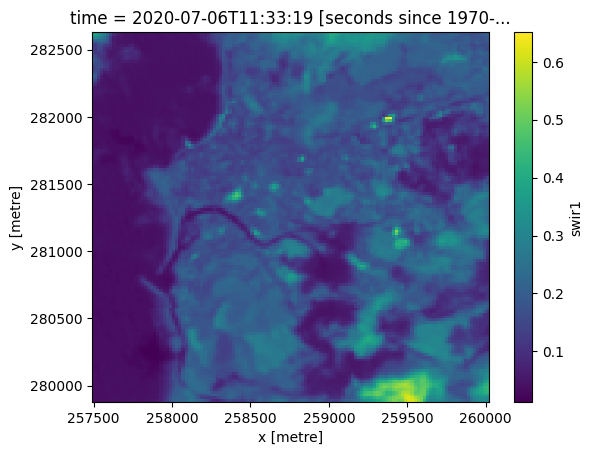

In [13]:
first_timestep.plot()

### Plotting multiple timesteps
It is often useful to produce plots for a single measurement across time, for example to compare change between satellite observations or summary datasets.
To plot multiple images, skip the `.isel()` / `.sel()` step above and plot the entire `xarray.DataArray` directly. 

To plot multiple timesteps in one figure, it is necessary to instruct the `.plot()` function to put each timestep in a different column.
This is done by specifying `.plot(col="time")`:

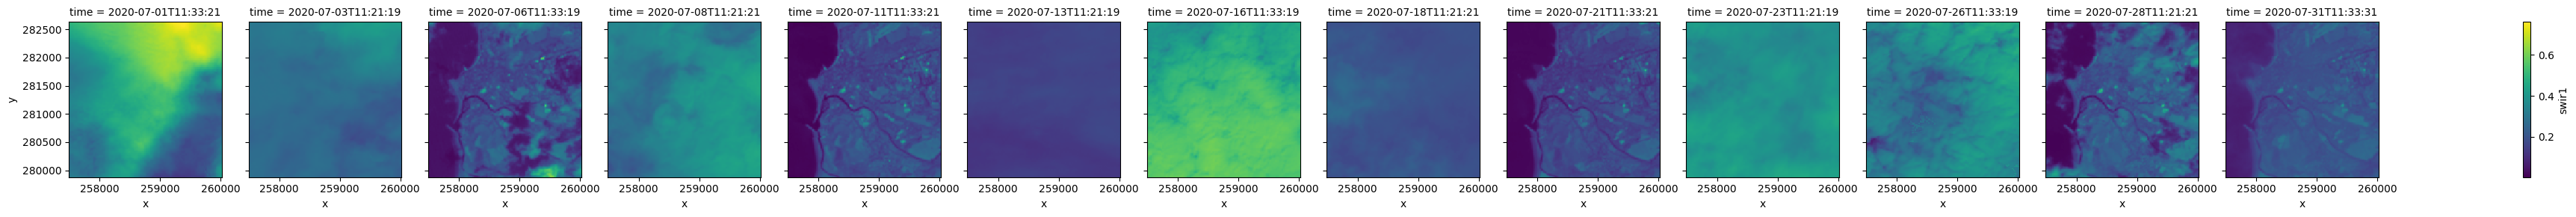

In [15]:
dataset.swir1.plot(col="time")


> This kind of plotting is called "facetted plotting". For more information, refer to the [xarray documentation](http://xarray.pydata.org/en/stable/plotting.html#faceting)

To specify the number of timesteps you can use the `col_wrap` argument as follows:

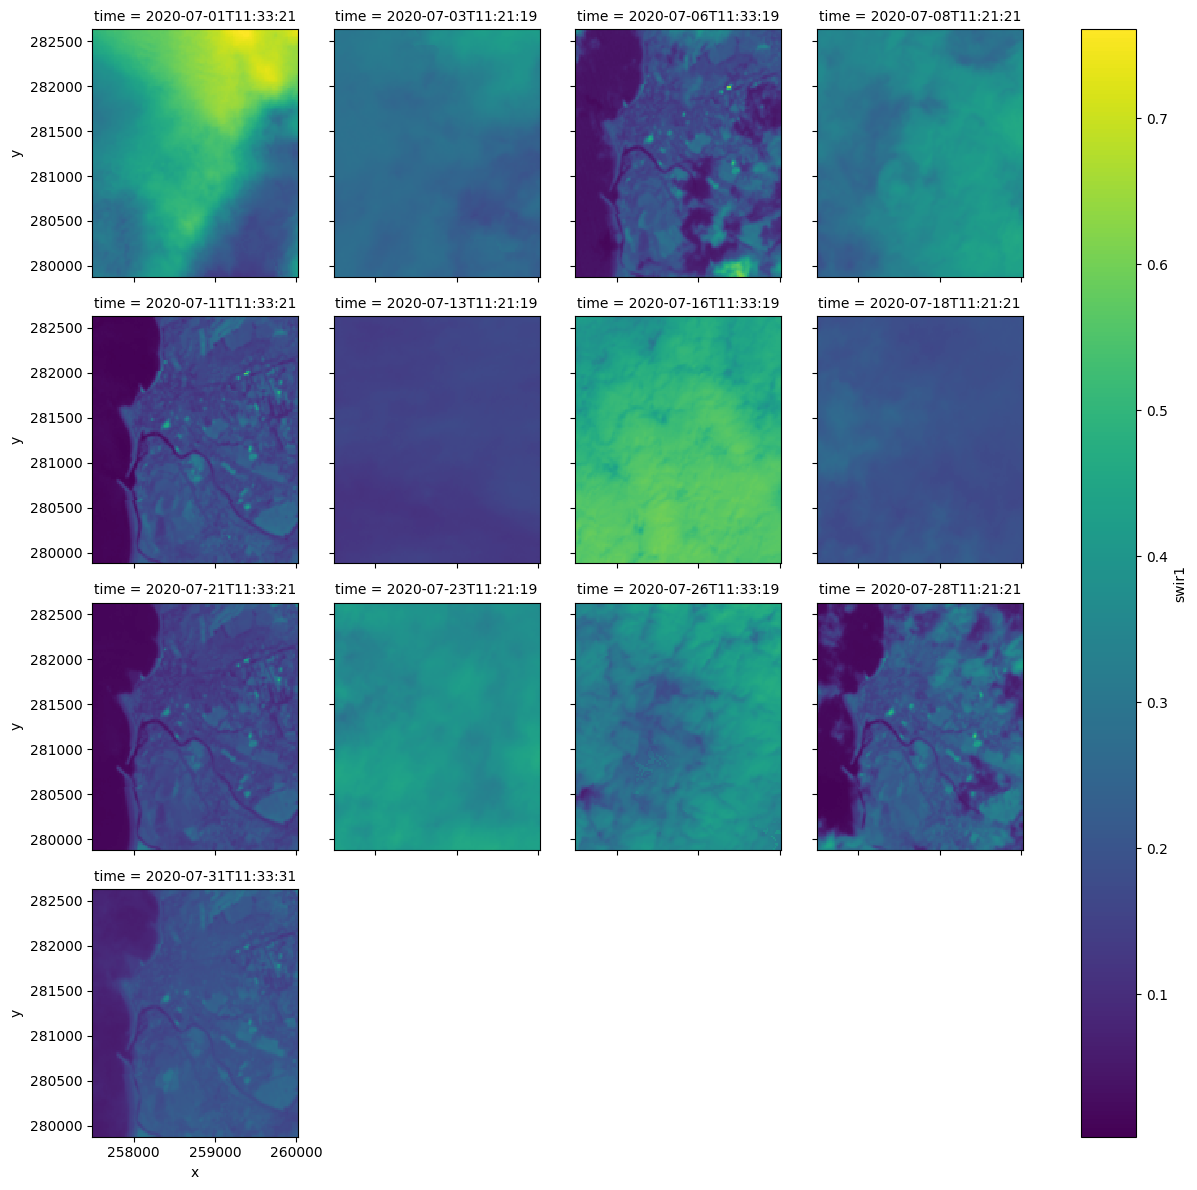

In [16]:
dataset.swir1.plot(col="time", col_wrap=4)

### Customising plot appearance
The plots above are dark and difficult to see clearly.
To improve the appearance of `xarray` plots, use the `robust=True` argument to optimise the plot colours by clipping extreme values or outliers. 
This will use the 2nd and 98th percentiles of the data to compute the color limits:

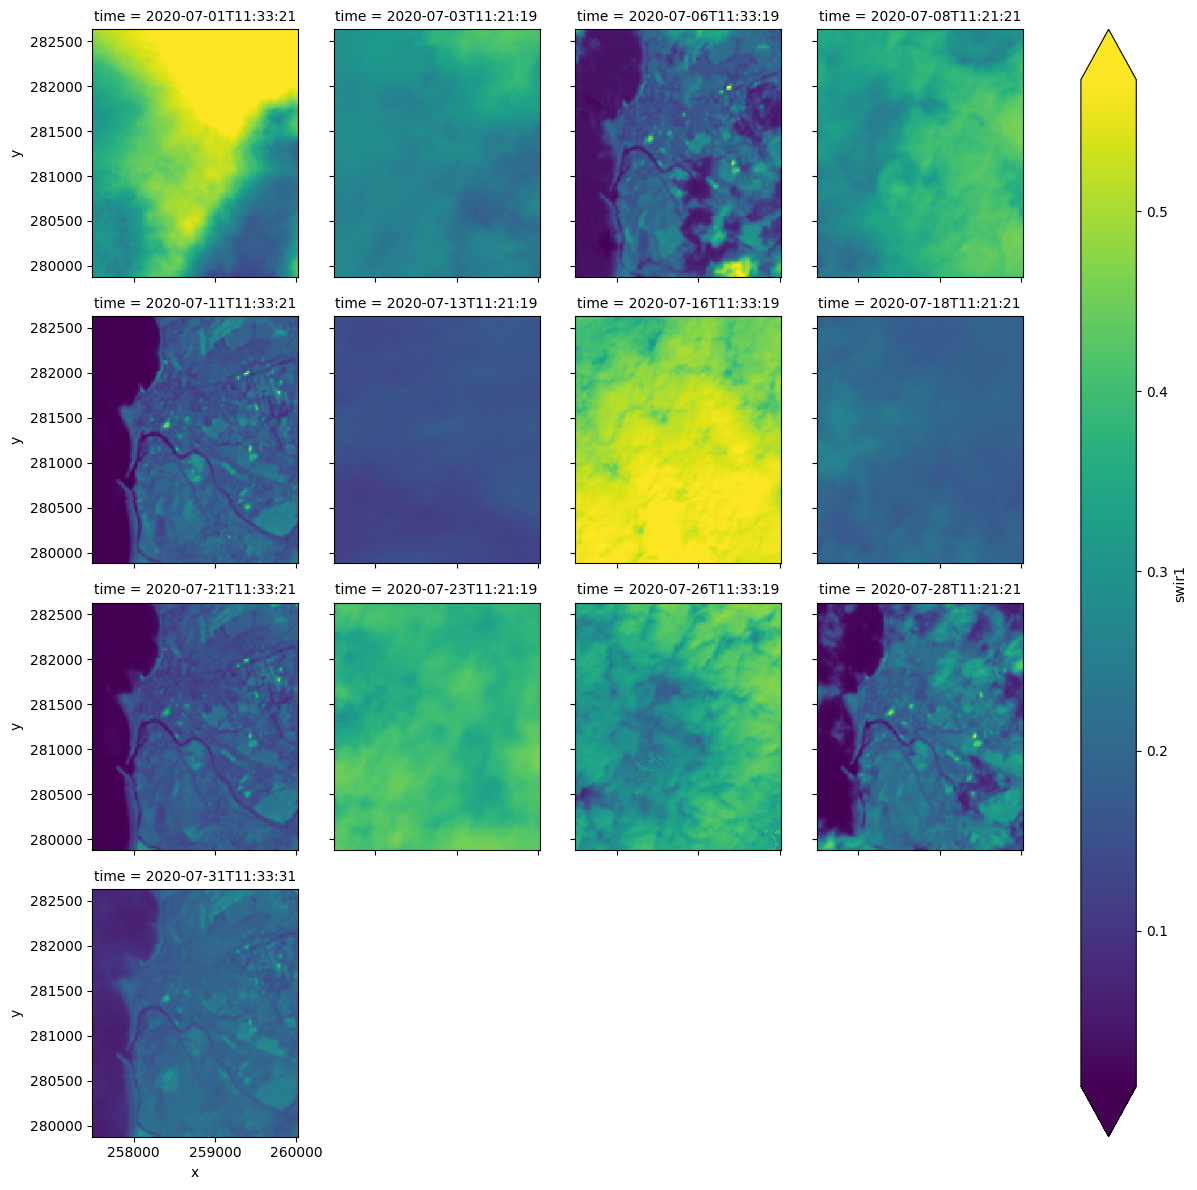

In [17]:
dataset.swir1.plot(col="time", col_wrap=4, robust=True)

Plots can be further customised by adding custom colour maps/styles using the `cmap` parameter.

When choosing a colour map for a plot, it is important to choose a set of colours that are perceived logically by the human eye. 
The best colour maps are "perceptually uniform": these colour maps increase logically from dark to light colours, where equal increases in lightness/darkness correspond to equal changes in data values. 
Some best-practice perceptually uniform colour maps include:

```
"viridis", "plasma", "inferno", "magma", "cividis"
```

> For further reading about perceptually uniform colour maps in data visualisation, refer to the [matplotlib documentation](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)

It is also important to consider colour blindness when selecting a colour map. 
`xarray` supports many colour maps from the "colorbrewer" family of colour maps which are optimised for colour blindness.
You can use the interactive [online tool](http://colorbrewer2.org) to browse all available colour maps, or choose from one of the following commonly used options:

```
"Greys", "Purples", "Blues", "Greens", "Oranges", "Reds",
"YlOrBr", "YlOrRd", "OrRd", "PuRd", "RdPu", "BuPu", 
"GnBu", "PuBu", "YlGnBu", "PuBuGn", "BuGn", "YlGn"
```

For a full list of available colour maps you can refer to [this list](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html).

The example cell below plots the data with the perceptually uniform `magma` colour map:


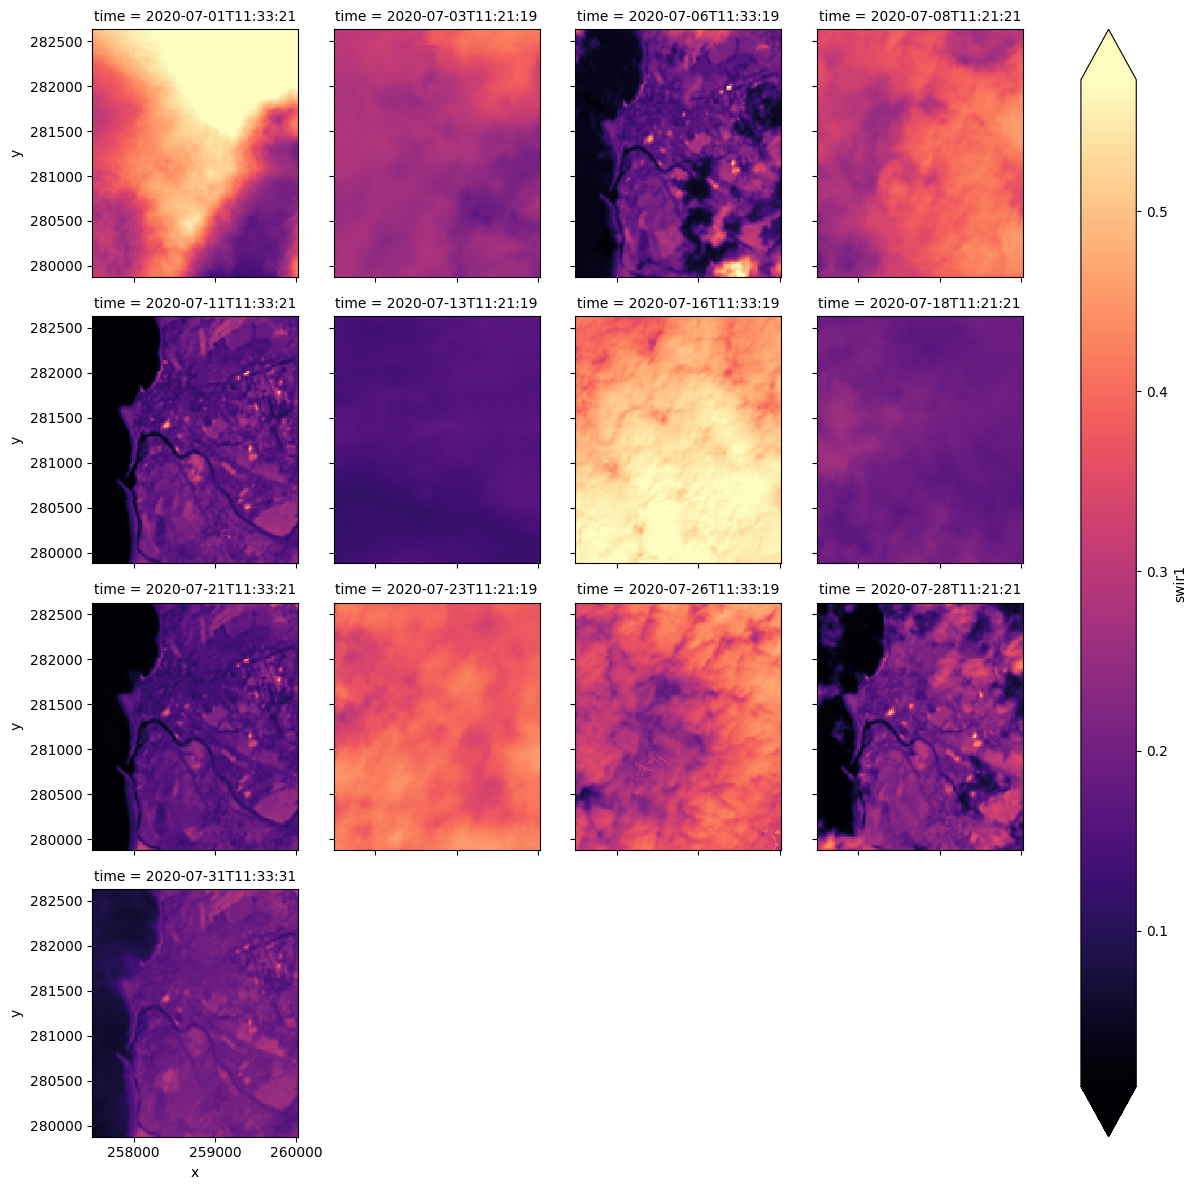

In [18]:
dataset.swir1.plot(col="time", col_wrap=4, robust=True, cmap="magma")

## Plotting true or false colour RGB images
Although `xarray` makes it easy to plot single band images, plotting a three band colour photo-like image is less straightforward.

To make this easier, Living Wales provides a custom `rgb()` function that is designed for plotting three band images.
The `rgb()` function maps three data variables/measurements from the loaded dataset to the red, green and blue channels that are used to make a three-colour image.

Providing the `red`, `green` and `blue` measurements from a dataset will produce a true colour image (i.e., how humans view the landscape).
Providing `nir`, `red` and `green` measurements or any other set of three satellite bands from a dataset will produce a false colour image.

> [Learn more about colour rendering](https://en.wikipedia.org/wiki/False_color#True_color).

Hence, the `rgb()` function can be used to visualise the data returned by a query.
It requires the minimum input of:

* `ds:` The `xarray.Dataset` object
* `bands:` Three bands for display (these must be measurements found in the dataset) 
* `index:` The timestep to view, default is `0`

### Plotting a single timestep

The time dimension of an `xarray.Dataset` describes how many timesteps exist for the loaded data.
In the `rgb()` function, the `index` variable is asking for which timesteps to view (similar to the `isel()` example above).
Remember: counting in Python begins at 0 so to view the earliest timesteps set `index=2`.

> *Hint*: To get the last image, you can use a time step value of `-1`

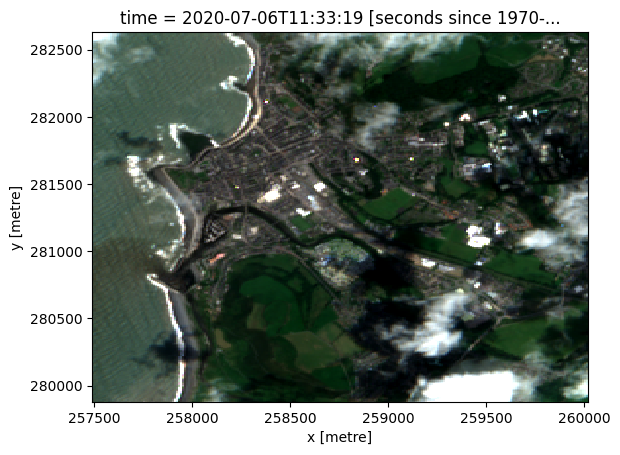

In [20]:
# View a red, green, blue (true colour) image of the first timestep
rgb(dataset, bands=["red", "green", "blue"], index=2, robust=True)

It is possible to change the input bands to plot a false colour image, which can provide different insights in a landscape.
The false colour band combination (`swir1`, `nir`, `green`) emphasises growing vegetation in green, and water in deep blue/black:

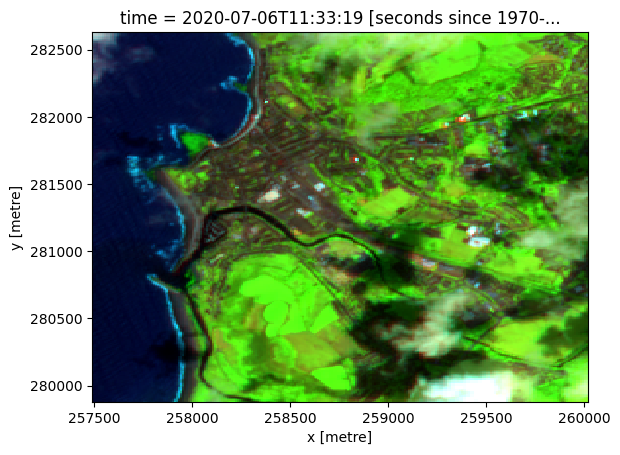

In [21]:
# View a swir1, nir, green (false colour) image of the first timestep
rgb(dataset, bands=['swir1', 'nir', 'green'], index=2, robust=True)

### Plotting multiple timesteps
As discussed in the [single band example above](#Plotting-multiple-timesteps), it can be useful to visualise multiple timesteps in a single plot (e.g. to compare change over time).

The `rgb()` function can also do this, as long as a list of timesteps to view is provided to the `index` argument, e.g. `index=[X1, X2, ...]`.
The example cell below plots the first and sixth image in the dataset using `index=[0, 5]` (remembering that counting in Python starts at 0):

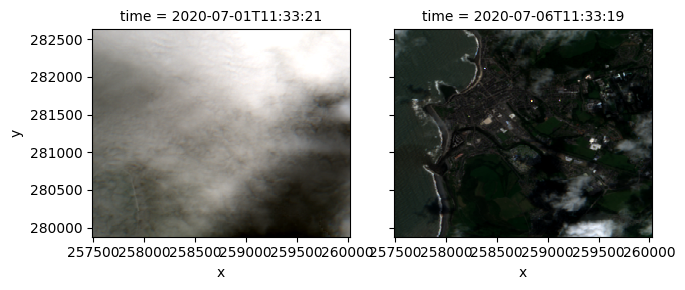

In [27]:
# View a true colour image for the first and third timesteps
rgb(dataset, bands=['red', 'green', 'blue'], index=[0, 2], robust=True)

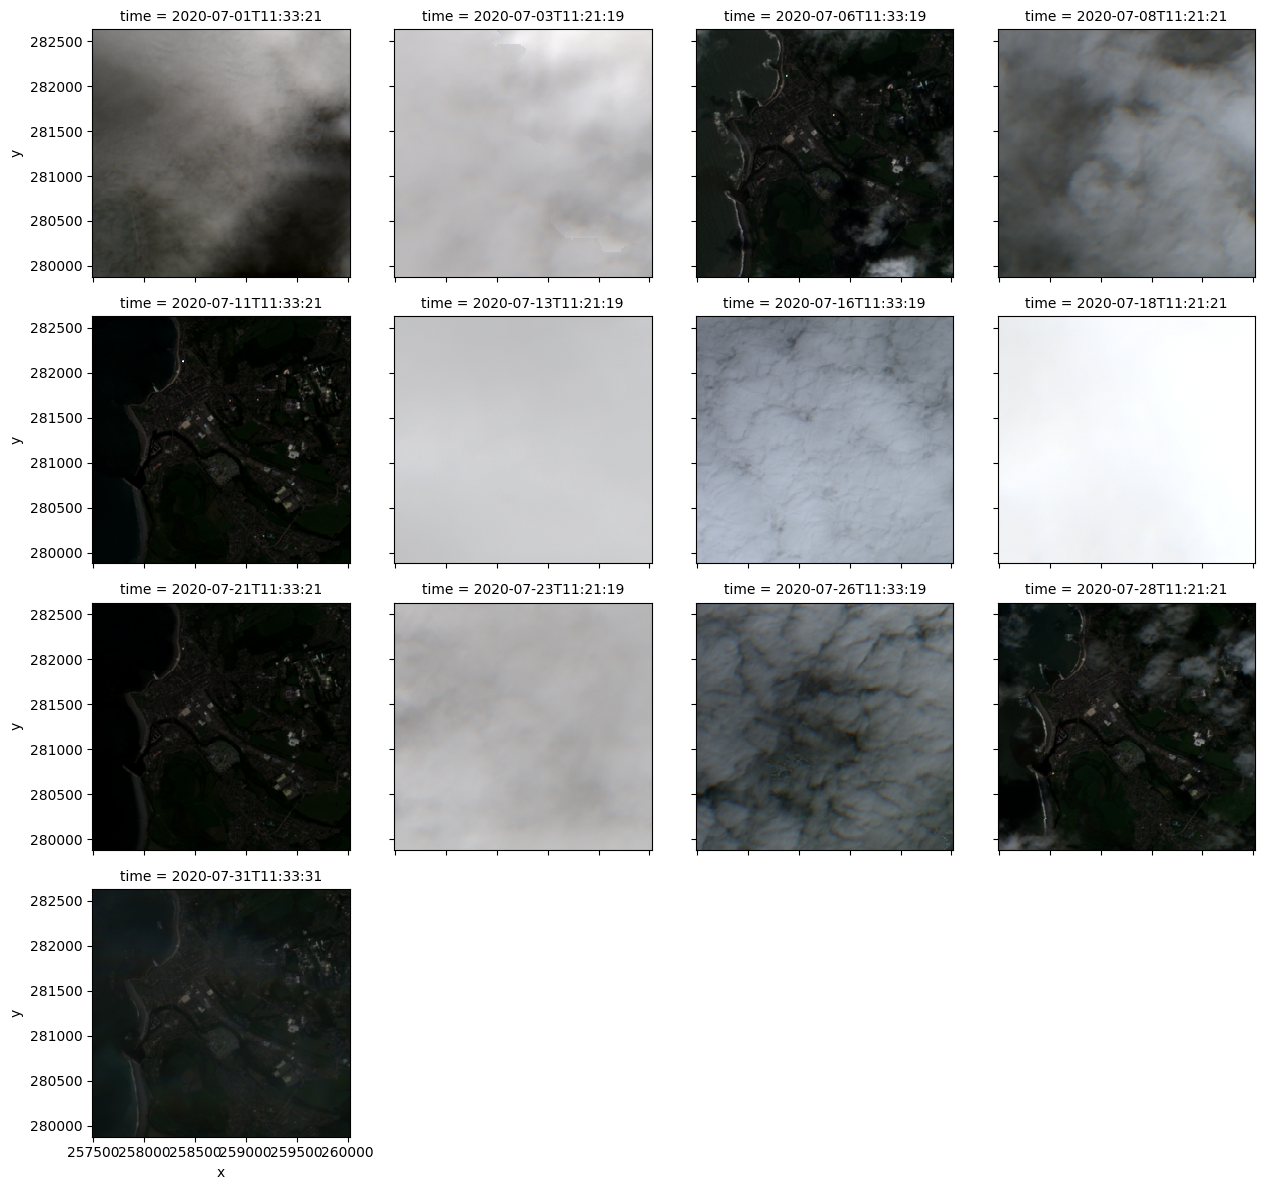

In [28]:
# Plot all timesteps in the dataset
rgb(dataset, bands=['red', 'green', 'blue'], col="time", robust=True)

### Customising plot appearance
By default, `rgb()` generates plots with `robust=True` to improve the appearance of the images by clipping out the darkest and brightest 2% of pixels, using the 2nd and 98th percentiles of the data to compute the colour limits

If this default provides poor results, the plot's colour stretch can be customised using the `percentile_stretch` parameter. 
This clips the most extreme minimum and maximum values in the dataset, improving the contrast and appearance of the plot.

For example, specifying `percentile_stretch=[0.02, 0.6]` will clip out the darkest and brightest 2% and 40% of pixels, respectively:

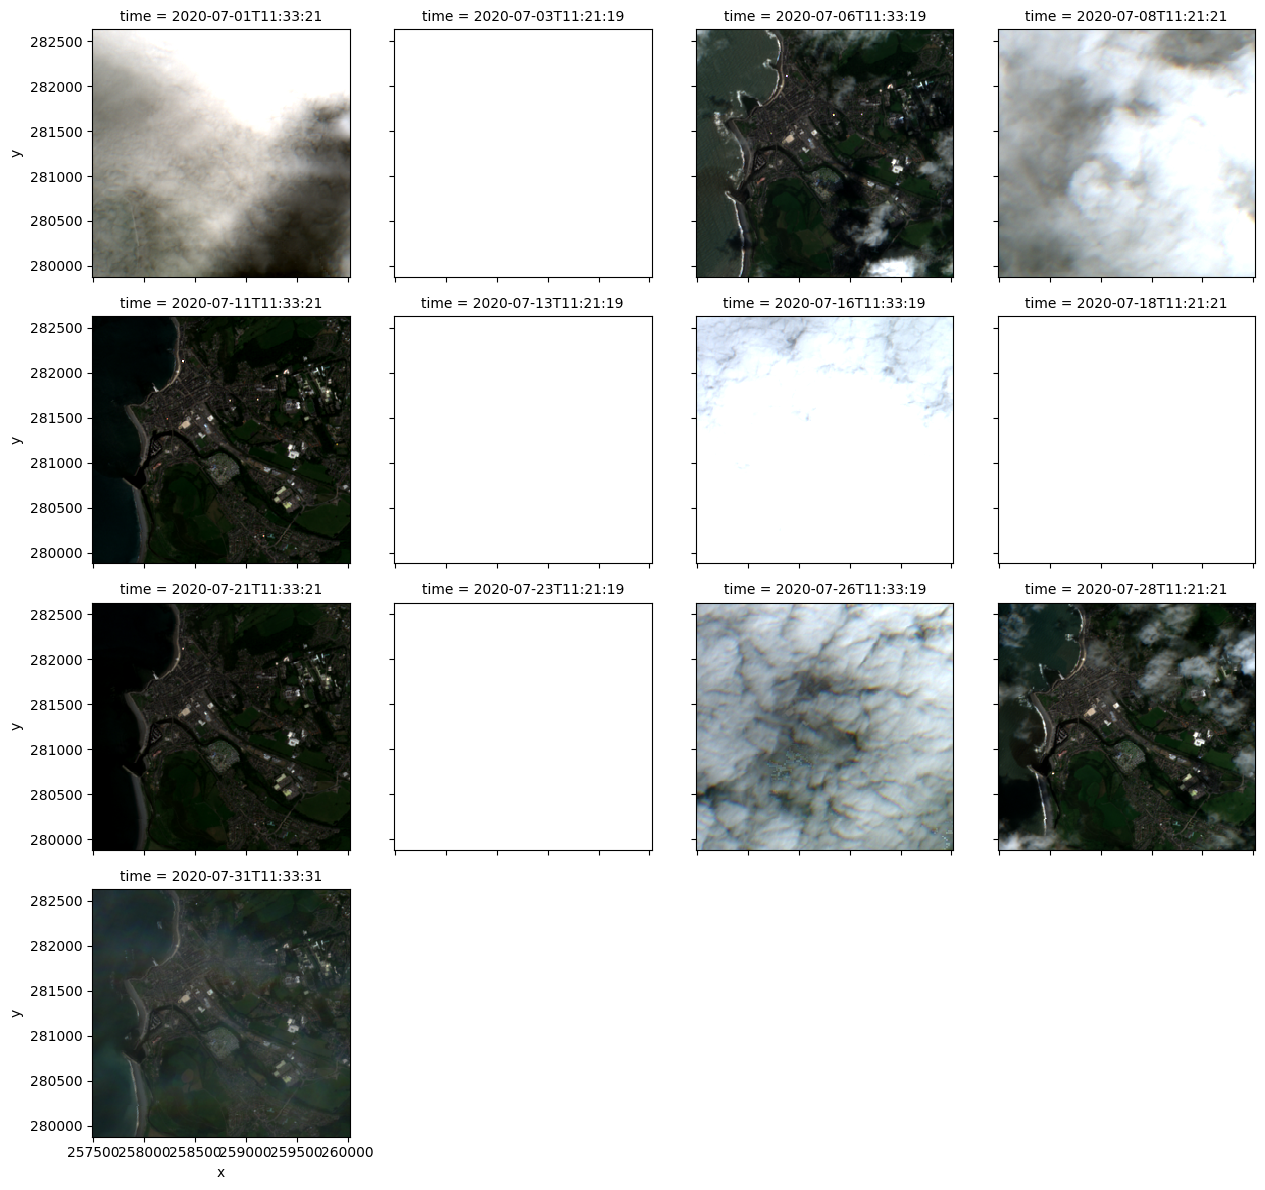

In [29]:
rgb(dataset, bands=['red', 'green', 'blue'], col="time", percentile_stretch=[0.02, 0.6])